In [3]:
import sys
import os

# Chemin du dossier parent
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import data.dataset as dataset
import data.transform as T_mtsk

# Import depuis models/
from models.architecture import BasicUNetWithClassification
from models.lightning_module import MultiTaskHemorrhageModule, MultiTaskHemorrhageModule_homeo, MultiTaskHemorrhageModule_gradnorm, MultiTaskSoftSharing

import utils

from monai.data import DataLoader, PersistentDataset
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torch
import os
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import config

import random

In [4]:

train_data=dataset.get_equalized_multitask_dataset('train')
random.shuffle(train_data)  # Mélange des données pour l'entraînement
val_data=dataset.get_equalized_multitask_dataset('val')

print(f"Nombre d'images d'entraînement : {len(train_data)}")
print(f"Nombre d'images de validation : {len(val_data)}")

print("Exemple d'entrée de train_data :", train_data[0])

print("visualisation de quel taches sont présentes dans les données d'entraînement :")
for item in train_data[:10]:
    print(f"  {item['task']}")
    
print("=== Test direct du dataset ===")
for i in range(min(4, len(train_data))):
    item = train_data[i]
    print(f"\nItem {i}:")
    print(f"  Task: {item.get('task')}")
    if 'image' in item:
        if isinstance(item['image'], list):
            print(f"  Image: LIST de {len(item['image'])} éléments")
            print(f"    Premier élément shape: {item['image'][0].shape if hasattr(item['image'][0], 'shape') else 'no shape'}")
        else:
            print(f"  Image shape: {item['image'].shape if hasattr(item['image'], 'shape') else 'no shape'}")

TRAIN - Positifs: 371 | Négatifs: 371
Nombre de données de segmentation : 154
Nombre de données de classification équilibrées : 742
VAL - Positifs: 92 | Négatifs: 92
Nombre de données de segmentation : 38
Nombre de données de classification équilibrées : 184
Nombre d'images d'entraînement : 896
Nombre d'images de validation : 222
Exemple d'entrée de train_data : {'image': '/home/tibia/Projet_Hemorragie/MBH_label_case/ID_d6d079fb_ID_87e0e65fa6.nii.gz', 'label': array([1., 0., 1., 1., 0., 0.], dtype=float32), 'task': 'classification'}
visualisation de quel taches sont présentes dans les données d'entraînement :
  classification
  classification
  segmentation
  classification
  segmentation
  segmentation
  classification
  classification
  classification
  classification
=== Test direct du dataset ===

Item 0:
  Task: classification
  Image shape: no shape

Item 1:
  Task: classification
  Image shape: no shape

Item 2:
  Task: segmentation
  Image shape: no shape

Item 3:
  Task: class

In [5]:
from monai.data import Dataset
import data.transform as T_mtsk

train_transforms, val_transforms = T_mtsk.TaskBasedTransform_V2(keys=["image", "label"]), T_mtsk.TaskBasedValTransform_V2(keys=["image", "label"])

import shutil

# Supprime complètement le cache
shutil.rmtree("./cache_dir", ignore_errors=True)

train_dataset = PersistentDataset(
        train_data, 
        transform=train_transforms,
        cache_dir="./cache_dir")


for i in range(15):
    print(f"Échantillon {i} :")
    for key, value in train_data[i].items():
         print(f"  - {key}: {value}")
print("Nombre total d'éléments dans le dataset:", len(train_data))

>>> TaskBasedTransform initialized
>>> TaskBasedValTransform initialized
Échantillon 0 :
  - image: /home/tibia/Projet_Hemorragie/MBH_label_case/ID_d6d079fb_ID_87e0e65fa6.nii.gz
  - label: [1. 0. 1. 1. 0. 0.]
  - task: classification
Échantillon 1 :
  - image: /home/tibia/Projet_Hemorragie/MBH_label_case/ID_5e05f9d0_ID_21fa164048.nii.gz
  - label: [1. 0. 1. 1. 1. 1.]
  - task: classification
Échantillon 2 :
  - image: /home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/img/ID_d2deede6_ID_799247e354.nii.gz
  - label: /home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/seg/ID_d2deede6_ID_799247e354.nii.gz
  - task: segmentation
Échantillon 3 :
  - image: /home/tibia/Projet_Hemorragie/MBH_label_case/ID_6d8b7494_ID_4ad1fd8947.nii.gz
  - label: [0. 0. 0. 0. 0. 0.]
  - task: classification
Échantillon 4 :
  - image: /home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/img/ID_96967deb_ID_5d782e9379.nii.gz
  - label: /home/tibia/Projet_Hemorragie/Seg_hemorragie/

/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [8]:
import pprint

loader = DataLoader(
    train_dataset, 
    batch_size=2, 
    shuffle=True, # Pour plus de clarté
    num_workers=0,
    collate_fn=utils.multitask_collate_fn # Utilisation de la fonction de collate personnalisée

)

# --- Exécution du Test ---
print(f"Dataset initial (volumes) : {len(train_data)}")
print(f"Batch Size (volumes) : {loader.batch_size}")
print("-" * 50)
print("Vérification de la taille des lots APRÈS l'application des patches (via collate_fn) :")

print (f"Nombre total de lots dans le DataLoader : {len(loader)}")
print("Résultat du premier lot :")
first_batch = next(iter(loader))

# Avec le call initial 

print("=== Infos générales ===")
print(f"type: {type(first_batch)}")
print(f"keys: {list(first_batch.keys())}")

print("=== Infos par clé ===")

cls_count = first_batch['classification']['image'].shape[0] if first_batch['classification'] is not None else 0
seg_count = first_batch['segmentation']['image'].shape[0] if first_batch['segmentation'] is not None else 0
total_patches = cls_count + seg_count

print(f"Patches de classification: {cls_count}")
print(f"Patches de segmentation: {seg_count}")

print(f"  shape : {list(first_batch['classification']["image"].shape)}")
print(f"  shape : {list(first_batch['segmentation']["image"].shape)}")

print("shape du label de classification :", first_batch['classification']['label'].shape)


Dataset initial (volumes) : 896
Batch Size (volumes) : 2
--------------------------------------------------
Vérification de la taille des lots APRÈS l'application des patches (via collate_fn) :
Nombre total de lots dans le DataLoader : 448
Résultat du premier lot :


/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile

=== Infos générales ===
type: <class 'dict'>
keys: ['classification', 'segmentation']
=== Infos par clé ===
Patches de classification: 18
Patches de segmentation: 2
  shape : [18, 1, 96, 96, 96]
  shape : [2, 1, 96, 96, 96]
shape du label de classification : torch.Size([18, 6])


 Test Dataloader utils 

In [22]:
import torch

# Votre fonction flatten
def flatten(batch):
    for item in batch:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item

# --- Création d'un batch d'exemple ---
# Nous simulerons des données simples (tenseurs) et une imbrication
# pour montrer que flatten fonctionne.

# Tenseurs aléatoires
tensor_A = torch.randn(3, 10)  # Tenseur de 3x10
tensor_B = torch.randn(3, 10)  # Tenseur de 3x10
tensor_C = torch.randn(3, 10)  # Tenseur de 3x10
tensor_D = torch.randn(3, 10)  # Tenseur de 3x10
tensor_E = torch.randn(3, 10)  # Tenseur de 3x10

# Batch imbriqué
# [ Élément simple, [ Liste d'éléments simples ], Élément simple, [ Liste imbriquée ] ]
example_batch = [
    tensor_A,
    [tensor_B, tensor_C],
    tensor_D,
    [[tensor_E]] # Double imbrication
]

print("--- 1. Structure du Batch (Avant flatten) ---")
print(f"Type de l'élément à l'index 1: {type(example_batch[1])}")
print(f"Longueur du batch: {len(example_batch)}")


# --- Test de la fonction flatten ---
flat_batch = list(flatten(example_batch))

print("\n--- 2. Structure du Batch (Après flatten) ---")
print(f"Type du résultat: {type(flat_batch)}")
print(f"Longueur du batch aplati: {len(flat_batch)}")

print("\n--- 3. Vérification des Tenseurs ---")

# On vérifie que les tenseurs originaux sont tous présents
print(f"Le Tenseur A est-il le premier élément? {flat_batch[0] is tensor_A}")
print(f"Le Tenseur E est-il le dernier élément? {flat_batch[-1] is tensor_E}")
print(f"Forme du premier élément aplati: {flat_batch[0].shape}")
print(f"Type du dernier élément aplati: {type(flat_batch[-1])}")
print(f"batch aplati complet: {flat_batch}")

--- 1. Structure du Batch (Avant flatten) ---
Type de l'élément à l'index 1: <class 'list'>
Longueur du batch: 4

--- 2. Structure du Batch (Après flatten) ---
Type du résultat: <class 'list'>
Longueur du batch aplati: 5

--- 3. Vérification des Tenseurs ---
Le Tenseur A est-il le premier élément? True
Le Tenseur E est-il le dernier élément? True
Forme du premier élément aplati: torch.Size([3, 10])
Type du dernier élément aplati: <class 'torch.Tensor'>
batch aplati complet: [tensor([[ 0.8457,  0.4845,  1.5668, -1.8926, -0.6487,  1.3580,  0.9388,  1.2377,
          1.1349, -0.7695],
        [-1.1854,  0.1463,  1.2118, -1.5987, -0.0058, -1.6769,  0.1111,  0.9685,
         -0.9121, -0.6517],
        [-1.3885, -1.3750,  0.7516,  1.0253,  0.2023,  0.6105,  0.7807,  1.9234,
         -0.6046,  1.6436]]), tensor([[-0.7419,  0.5092, -0.0504, -1.5096, -1.2095, -2.1121,  0.1571, -0.8586,
         -0.2099, -0.7358],
        [ 0.5918,  1.1614,  1.2502, -0.4430,  2.1776, -0.8310,  1.3217, -0.2493,
 

In [2]:
# Test view du forward classification multi-patch
import torch
tensor_test = torch.randn(36, 1, 96, 96, 96)  # Simule un batch de 18 patches avec batch_size = 2
batch_size = 2  # Supposons que nous avons 2 images dans le batc

num_patches = tensor_test.shape[0] // batch_size  # Nombre de patches par image
print(f"Nombre de patches par image: {num_patches}")
print("Forme d'un patch (déballée) :" ,  *tensor_test.shape[1:])
argument_view = (batch_size, num_patches, *tensor_test.shape[1:])

# X est de la shape : [B*N, C, H, W, D]
x_reshaped = tensor_test.view(batch_size, num_patches, *tensor_test.shape[1:])
print(f"Shape après view: {x_reshaped.shape}")# Devrait être [2, 18, 1, 96, 96, 96]

# Test du forward attention multi-patch
model = BasicUNetWithClassification(in_channels=1, out_channels=6, features=(32, 32, 64, 128, 256, 32), num_cls_classes=6)
# X est de la shape : [B*N, C, H, W, D]
output_seg, output_cls = model(tensor_test, task="classification", batch_size=batch_size)
print(f"Output segmentation shape: {output_seg}")  # Devrait être None
print(f"Output classification shape: {output_cls.shape}")  # Devrait être [B, num_cls_classes] soit [2, 2]

Nombre de patches par image: 18
Forme d'un patch (déballée) : 1 96 96 96
Shape après view: torch.Size([2, 18, 1, 96, 96, 96])
BasicUNet features: (32, 32, 64, 128, 256, 32).
--- Début du Forward Pass ---
0. Shape d'entrée (x): torch.Size([2, 18, 256, 6, 6, 6])
   -> B=2, N=18, C=256, H=6, W=6, D=6

1. Reshape 'batchifié' (x_reshaped): torch.Size([36, 256, 6, 6, 6])
2. Après AdaptiveAvgPool3d (pooled): torch.Size([36, 256, 1, 1, 1])
3. Aplatir pour MLP (pooled_flat): torch.Size([36, 256])
4. Scores de 'gate_nn' (scores): torch.Size([36, 1])
5. Reshape des scores (scores_by_batch): torch.Size([2, 18])
6. Poids d'attention (weights): torch.Size([2, 18])
7. Poids 'broadcastés' (weights_broadcast): torch.Size([2, 18, 1, 1, 1, 1])
8. Features pondérées (weighted_features): torch.Size([2, 18, 256, 6, 6, 6])
9. Agrégation (sum dim=1) (aggregated): torch.Size([2, 256, 6, 6, 6])
--- Fin du Forward Pass ---
Output segmentation shape: None
Output classification shape: torch.Size([2, 6])


In [18]:
#Test module de patch attention aggregation
import torch
import torch.nn as nn

# -------------------------------------------------------------------
# 1. VOTRE CLASSE (modifiée avec des print pour l'explication)
# -------------------------------------------------------------------
class PatchAttentionAggregator(nn.Module):
    """
    Module d'agrégation par attention (Multiple Instance Learning).
    Prend [B, N, C, H, W, D] et retourne [B, C, H, W, D]
    """
    def __init__(self, in_channels: int, hidden_channels: int = 256):
        super().__init__()
        print(f"--- Initialisation du Modèle ---")
        print(f"in_channels (C): {in_channels}")
        print(f"hidden_channels (MLP): {hidden_channels}")
        
        # 1. Un "pooler" pour obtenir un vecteur par patch
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        
        # 2. Un réseau "gating" pour calculer le score de chaque patch
        self.gate_nn = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.LeakyReLU(inplace=True),
            nn.Linear(hidden_channels, 1) # Sortie : 1 score par patch
        )
        
        # 3. Softmax pour normaliser les scores en poids (somme=1)
        self.softmax = nn.Softmax(dim=1) # Appliquer sur la dimension N
        print("---------------------------------\n")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: Tenseur d'entrée de forme [B, N, C, H, W, D]
        """
        print("--- Début du Forward Pass ---")
        print(f"0. Shape d'entrée (x): {x.shape}")
        
        # Sauvegarde des dimensions
        B, N, C, H, W, D = x.shape
        print(f"   -> B={B}, N={N}, C={C}, H={H}, W={W}, D={D}")
        
        # 1. Reshape pour traiter les N patchs comme un batch
        # [B, N, C, H, W, D] -> [B*N, C, H, W, D]
        x_reshaped = x.view(-1, C, H, W, D)
        print(f"\n1. Reshape 'batchifié' (x_reshaped): {x_reshaped.shape}")
        
        # 2. Pooler : résume chaque patch en 1 vecteur
        # [B*N, C, H, W, D] -> [B*N, C, 1, 1, 1]
        pooled = self.pool(x_reshaped)
        print(f"2. Après AdaptiveAvgPool3d (pooled): {pooled.shape}")
        
        # Aplatir pour le MLP
        # [B*N, C, 1, 1, 1] -> [B*N, C]
        pooled_flat = pooled.view(B * N, C)
        print(f"3. Aplatir pour MLP (pooled_flat): {pooled_flat.shape}")
        
        # 3. Gating : Calcule le score (logit) pour chaque patch
        # [B*N, C] -> [B*N, 1]
        scores = self.gate_nn(pooled_flat)
        print(f"4. Scores de 'gate_nn' (scores): {scores.shape}")
        
        # 4. Reshape pour Softmax : regroupe les scores par batch original
        # [B*N, 1] -> [B, N]
        scores_by_batch = scores.view(B, N)
        print(f"5. Reshape des scores (scores_by_batch): {scores_by_batch.shape}")
        
        # 5. Softmax : Calcule les poids d'attention
        # Les poids des N patchs pour chaque item du batch somment à 1
        # [B, N]
        weights = self.softmax(scores_by_batch)
        print(f"6. Poids d'attention (weights): {weights.shape}")
        
        # 6. Agrandir les poids pour la multiplication (broadcasting)
        # [B, N] -> [B, N, 1, 1, 1, 1]
        weights_broadcast = weights.view(B, N, 1, 1, 1, 1)
        print(f"7. Poids 'broadcastés' (weights_broadcast): {weights_broadcast.shape}")
        
        # 7. Appliquer les poids :
        # [B, N, C, H, W, D] * [B, N, 1, 1, 1, 1] -> [B, N, C, H, W, D]
        weighted_features = x * weights_broadcast
        print(f"8. Features pondérées (weighted_features): {weighted_features.shape}")
        
        # 8. Agréger (somme pondérée)
        # torch.sum sur la dim N -> [B, C, H, W, D]
        aggregated = torch.sum(weighted_features, dim=1)
        print(f"9. Agrégation (sum dim=1) (aggregated): {aggregated.shape}")
        
        print("--- Fin du Forward Pass ---")
        return aggregated

# -------------------------------------------------------------------
# 2. MISE EN PLACE DU TEST
# -------------------------------------------------------------------

# Définissons nos dimensions de test
B = 2   # Batch size (2 images)
N = 18  # Nombre de patches par image
C = 1  # Canaux (features) du tenseur d'entrée
H = 96  # Hauteur d'un patch
W = 96  # Largeur d'un patch
D = 96  # Profondeur d'un patch

# 1. Instancier le modèle
#    'in_channels' doit correspondre à C
model = PatchAttentionAggregator(in_channels=C, hidden_channels=128)

# 2. Créer un tenseur de test aléatoire
#    Shape: [B, N, C, H, W, D]
test_tensor = torch.randn(B, N, C, H, W, D)

print(f"Lancement du test avec un tenseur de shape: {test_tensor.shape}\n")

# 3. Exécuter le forward pass
output = model(test_tensor)

# 4. Vérifier la sortie
print(f"\nShape finale en sortie: {output.shape}")
print(f"La shape finale [B, C, H, W, D] est-elle correcte ? {output.shape == (B, C, H, W, D)}")

--- Initialisation du Modèle ---
in_channels (C): 1
hidden_channels (MLP): 128
---------------------------------

Lancement du test avec un tenseur de shape: torch.Size([2, 18, 1, 96, 96, 96])

--- Début du Forward Pass ---
0. Shape d'entrée (x): torch.Size([2, 18, 1, 96, 96, 96])
   -> B=2, N=18, C=1, H=96, W=96, D=96

1. Reshape 'batchifié' (x_reshaped): torch.Size([36, 1, 96, 96, 96])
2. Après AdaptiveAvgPool3d (pooled): torch.Size([36, 1, 1, 1, 1])
3. Aplatir pour MLP (pooled_flat): torch.Size([36, 1])
4. Scores de 'gate_nn' (scores): torch.Size([36, 1])
5. Reshape des scores (scores_by_batch): torch.Size([2, 18])
6. Poids d'attention (weights): torch.Size([2, 18])
7. Poids 'broadcastés' (weights_broadcast): torch.Size([2, 18, 1, 1, 1, 1])
8. Features pondérées (weighted_features): torch.Size([2, 18, 1, 96, 96, 96])
9. Agrégation (sum dim=1) (aggregated): torch.Size([2, 1, 96, 96, 96])
--- Fin du Forward Pass ---

Shape finale en sortie: torch.Size([2, 1, 96, 96, 96])
La shape fina

# Répartition dataset

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

csv_path = Path("/home/tibia/Projet_Hemorragie/MBH_label_case/case-wise_annotation.csv")
label_cols = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
df = pd.read_csv(csv_path)

def visualize_label_distribution(label_file_counts, total_files):
    fig = plt.figure(figsize=(20, 12))
    
    labels = list(range(6))
    counts = [label_file_counts[i] for i in labels]
    label_names = ['Background', 'EDH', 'IPH', 'IVH', 'SAH', 'SDH']
    
    colors = ['#2C3E50', '#E74C3C', '#3498DB', '#F39C12', '#9B59B6', '#1ABC9C']
    
    ax1 = plt.subplot(2, 3, 1)
    bars = ax1.bar(labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax1.set_xlabel('Label', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
    ax1.set_title('Files Containing Each Label', fontsize=14, fontweight='bold')
    ax1.set_xticks(labels)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    ax2 = plt.subplot(2, 3, 2)
    percentages = [(count/total_files)*100 for count in counts]
    bars2 = ax2.barh(label_names, percentages, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax2.set_xlabel('Percentage of Files (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Percentage Distribution', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    for i, (bar, pct) in enumerate(zip(bars2, percentages)):
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{pct:.1f}%', ha='left', va='center', fontweight='bold')
    
    ax3 = plt.subplot(2, 3, 3)
    hemorrhage_counts = counts[1:]
    hemorrhage_labels = label_names[1:]
    hemorrhage_colors = colors[1:]
    
    wedges, texts, autotexts = ax3.pie(hemorrhage_counts, labels=hemorrhage_labels, 
                                       colors=hemorrhage_colors, autopct='%1.1f%%',
                                       startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
    ax3.set_title('Hemorrhage Types Distribution\n(Excluding Background)', fontsize=14, fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax4 = plt.subplot(2, 3, 4)
    background_count = counts[0]
    lesion_counts = counts[1:]
    
    bottom = 0
    bar_width = 0.6
    
    ax4.bar('Dataset', background_count, bar_width, label='Background', 
            color=colors[0], alpha=0.8, edgecolor='black', linewidth=1)
    bottom += background_count
    
    for i, (count, color, name) in enumerate(zip(lesion_counts, colors[1:], label_names[1:])):
        ax4.bar('Dataset', count, bar_width, bottom=bottom, label=name,
                color=color, alpha=0.8, edgecolor='black', linewidth=1)
        bottom += count
    
    ax4.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
    ax4.set_title('Stacked Distribution', fontsize=14, fontweight='bold')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax5 = plt.subplot(2, 3, 5)
    wedges, texts = ax5.pie(counts, labels=labels, colors=colors, 
                           wedgeprops=dict(width=0.5), startangle=90)
    
    ax5.text(0, 0, f'Total\n{total_files}\nFiles', ha='center', va='center',
             fontsize=14, fontweight='bold')
    ax5.set_title('Complete Distribution\n(Donut Chart)', fontsize=14, fontweight='bold')
    
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    summary_data = []
    for i, (label, count, name) in enumerate(zip(labels, counts, label_names)):
        pct = (count/total_files)*100
        summary_data.append([f'Label {label}', name, count, f'{pct:.1f}%'])
    
    summary_data.append(['', 'TOTAL FILES', total_files, '100.0%'])
    summary_data.append(['', 'Files w/ Lesions', (df['any'] == 1).sum(), ''])
    
    table = ax6.table(cellText=summary_data,
                     colLabels=['Label', 'Type', 'Count', 'Percentage'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.15, 0.45, 0.2, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    for i in range(len(summary_data) + 1):
        for j in range(4):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#34495E')
                cell.set_text_props(weight='bold', color='white')
            elif i == len(summary_data) - 1 or i == len(summary_data):
                cell.set_facecolor('#ECF0F1')
                cell.set_text_props(weight='bold')
            else:
                cell.set_facecolor(colors[i-1] if i-1 < len(colors) else '#FFFFFF')
                if i-1 == 0:
                    cell.set_text_props(color='white', weight='bold')
    
    ax6.set_title('Summary Statistics', fontsize=14, fontweight='bold')
    
    plt.suptitle('Hemorrhage Dataset Annotation Distribution Analysis', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()
    
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Total files: {total_files}")
    print(f"Files with background (Label 0): {counts[0]} ({counts[0]/total_files*100:.1f}%)")
    print("Files with hemorrhage types:")
    for i in range(1, 6):
        pct = (counts[i]/total_files)*100
        print(f"  Label {i}: {counts[i]} files ({pct:.1f}%)")
    
    total_lesion_files_present = (df['any'] == 1).sum()
    print(f"\nFiles with at least one hemorrhage (any=1): {total_lesion_files_present}")

total_files = len(df)
label_file_counts = [0] * 6
label_file_counts[0] = (df['any'] == 0).sum() # Background (no hemorrhage)
label_file_counts[1] = (df['epidural'] == 1).sum()
label_file_counts[2] = (df['intraparenchymal'] == 1).sum()
label_file_counts[3] = (df['intraventricular'] == 1).sum()
label_file_counts[4] = (df['subarachnoid'] == 1).sum()
label_file_counts[5] = (df['subdural'] == 1).sum()

visualize_label_distribution(label_file_counts, total_files)

### Deboggage modèle / architecture

In [2]:
import torch


model = MultiTaskHemorrhageModule(num_steps=150 * config.num_epochs)
# Crée des données de test
x_cls_test = torch.randn(12, 1, 96, 96, 96)  # 12 patches de classification
x_seg_test = torch.randn(2, 1, 96, 96, 96)   # 2 patches de segmentation

print("=== Test du modèle ===")

# Test classification
try:
    result_cls = model(x_cls_test, task="classification")
    print(f"✓ Classification OK")
    print(f"  Type: {type(result_cls)}")
    print(f"  Contenu: {result_cls}")
    if isinstance(result_cls, tuple):
        print(f"  Élément 0: {result_cls[0]}")
        print(f"  Élément 1: {type(result_cls[1])}, shape: {result_cls[1].shape if result_cls[1] is not None else 'None'}")
except Exception as e:
    print(f"✗ Erreur classification: {e}")

# Test segmentation
try:
    result_seg = model(x_seg_test, task="segmentation")
    print(f"✓ Segmentation OK")
    print(f"  Type: {type(result_seg)}")
    print(f"  Contenu: {result_seg}")
    if isinstance(result_seg, tuple):
        print(f"  Élément 0: {type(result_seg[0])}, shape: {result_seg[0].shape if result_seg[0] is not None else 'None'}")
        print(f"  Élément 1: {result_seg[1]}")
except Exception as e:
    print(f"✗ Erreur segmentation: {e}")

BasicUNet features: (32, 32, 64, 128, 256, 32).
Répartition des poids : tensor([1., 1., 1., 1., 1., 1.])
=== Test du modèle ===
✗ Erreur classification: MultiTaskHemorrhageModule.forward() got an unexpected keyword argument 'task'
✗ Erreur segmentation: MultiTaskHemorrhageModule.forward() got an unexpected keyword argument 'task'


# Sliding window

In [5]:
import torch
import itertools

def extract_sliding_window_patches(image_tensor, label, roi_size=(96, 96, 96), overlap=0.25):
    """
    Extrait patches avec sliding window.
    
    Args:
        image_tensor: Tensor [C, H, W, D]
        label: Label de classification
        roi_size: Taille des patches
        overlap: Pourcentage de chevauchement (0.0 à 0.99)
    
    Returns:
        Liste de dicts avec 'image', 'label', 'task'
    """
    C, H, W, D = image_tensor.shape
    
    # Calcule le stride
    stride = tuple(int(r * (1 - overlap)) for r in roi_size)
    print(f"Stride calculé: {stride}")
    
    # # Génère les positions de départ pour chaque dimension
    def get_starts(dim_size, roi_dim, stride_dim):
        starts = list(range(0, dim_size - roi_dim + 1, stride_dim))
        # Assure la couverture complète
        if starts[-1] + roi_dim < dim_size:
            starts.append(dim_size - roi_dim)
        return starts
    
    h_starts = get_starts(H, roi_size[0], stride[0])
    print(f"Positions de départ en hauteur: {h_starts}")
    w_starts = get_starts(W, roi_size[1], stride[1])
    print(f"Positions de départ en largeur: {w_starts}")
    d_starts = get_starts(D, roi_size[2], stride[2])
    print(f"Positions de départ en profondeur: {d_starts}")
    
    patches = []
    for h, w, d in itertools.product(h_starts, w_starts, d_starts):
        patch = image_tensor[
            :,
            h:h + roi_size[0],
            w:w + roi_size[1],
            d:d + roi_size[2]
        ]
        
        patches.append({
            "image": patch,
            "label": label,
            "task": "classification"
        })
        
         

    

    return patches

# TEST
print("=== Test de la fonction ===")
test_img = torch.randn(1, 240, 240, 148)
test_label = torch.tensor([1, 0, 1, 0, 0, 1])

patches = extract_sliding_window_patches(test_img, test_label, overlap=0.25)

print(f"Nombre de patches: {len(patches)}")
print(f"Shape du premier patch: {patches[0]['image'].shape}")
# print(f"liste des coordonnée s des patches :")

# # Boucle sur la liste de dictionnaires
# for i, patch_info in enumerate(patches):
#     # Accède à l'information stockée sous la clé 'coords'
#     coords = patch_info['coords'] 
#     print(f"Patch {i + 1}: (h={coords[0]}, w={coords[1]}, d={coords[2]})")

=== Test de la fonction ===
Stride calculé: (72, 72, 72)
Positions de départ en hauteur: [0, 72, 144]
Positions de départ en largeur: [0, 72, 144]
Positions de départ en profondeur: [0, 52]
Nombre de patches: 18
Shape du premier patch: torch.Size([1, 96, 96, 96])


Transformées

In [7]:
import monai.transforms as T

cls_pipeline = T.Compose([
            T.LoadImaged(keys=["image"], image_only=True),
            T.EnsureChannelFirstd(keys=["image"]),
            T.Orientationd(keys=["image"], axcodes='RAS'),
            T.Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
            T.CropForegroundd(keys=["image"], source_key='image'),
            T.ScaleIntensityRanged(
                keys=["image"],
                a_min=-10,a_max=140, 
                b_min=0.0, b_max=1.0, 
                clip=True),
            #T.ToTensord(keys=["image", "label"]) 
            ])

seg_pipeline = T.Compose([
            T.LoadImaged(keys=["image", "label"], image_only=False),
            T.EnsureChannelFirstd(keys=["image", "label"]),
            T.CropForegroundd(keys=["image", "label"], source_key='image'),
            T.Orientationd(keys=["image", "label"], axcodes='RAS'),
            T.Spacingd(keys=["image", "label"], pixdim=(1., 1., 1.), mode=["bilinear", "nearest"]),
            T.SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 96)),
            T.ScaleIntensityRanged(
                keys=["image"],
                a_min=-10,
                a_max=140,
                b_min=0.0, b_max=1.0, clip=True
            )
        ])

/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


 Test avec classification

In [8]:
import itertools
from monai import transforms as T

# Charge UNE image de classification du dataset
train_data = dataset.get_equalized_multitask_dataset('train')

# Trouve la première image de classification
cls_item = None
for item in train_data:
    if item['task'] == 'classification':
        cls_item = item
        break

print(f"Image trouvée: {cls_item['image']}")
image_load= T.LoadImage(image_only=True)(cls_item['image'])
print(f"Image shape (avant preprocessing): {image_load.shape}")
print(f"Label: {cls_item['label']}")

# Applique le preprocessing

processed = cls_pipeline(cls_item)

print(f"\n=== Après preprocessing ===")
print(f"Image shape: {processed['image'].shape}")
print(f"Label shape: {processed['label'].shape}")

# # Teste la fonction de sliding window
patches = extract_sliding_window_patches(
    processed['image'], 
    processed['label'],
    roi_size=(96, 96, 96),
    overlap=0.25
)

print(f"\n=== Patches générés ===")
print(f"Nombre total: {len(patches)}")
print(f"Premier patch image shape: {patches[0]['image'].shape}")
# print(f"Premier patch label: {patches[0]['label']}")
# print(f"Premier patch task: {patches[0]['task']}")

# Vérifie que tous les patches ont la bonne shape
for i, p in enumerate(patches):
    assert p['image'].shape == (1, 96, 96, 96), f"Patch {i} a une mauvaise shape: {p['image'].shape}"
    
print("\n✓ Tous les patches ont la bonne shape!")

TRAIN - Positifs: 371 | Négatifs: 371
Nombre de données de segmentation : 154
Nombre de données de classification équilibrées : 742
Image trouvée: /home/tibia/Projet_Hemorragie/MBH_label_case/ID_18eadbf5_ID_c07eadce67.nii.gz
Image shape (avant preprocessing): torch.Size([512, 512, 31])
Label: [1. 0. 0. 0. 1. 0.]

=== Après preprocessing ===
Image shape: torch.Size([1, 199, 201, 155])
Label shape: (6,)
Stride calculé: (72, 72, 72)
Positions de départ en hauteur: [0, 72, 103]
Positions de départ en largeur: [0, 72, 105]
Positions de départ en profondeur: [0, 59]

=== Patches générés ===
Nombre total: 18
Premier patch image shape: torch.Size([1, 96, 96, 96])

✓ Tous les patches ont la bonne shape!


Test avec segmentation

In [3]:
import itertools
from monai import transforms as T

# Charge UNE image de classification du dataset
train_data = dataset.get_equalized_multitask_dataset('train')

# Trouve la première image de classification
cls_item = None
for item in train_data:
    if item['task'] == 'segmentation':
        seg_item = item
        break

print(f"Image trouvée: {seg_item['image']}")
image_load= T.LoadImage(image_only=True)(seg_item['image'])
print(f"Image shape (avant preprocessing): {image_load.shape}")
print(f"Label: {seg_item['label']}")

# Applique le preprocessing

processed = seg_pipeline(seg_item)

print(f"\n=== Après preprocessing ===")
print(f"Image shape: {processed['image'].shape}")
print(f"Label shape: {processed['label'].shape}")

# # Teste la fonction de sliding window
patches = extract_sliding_window_patches(
    processed['image'], 
    processed['label'],
    roi_size=(96, 96, 96),
    overlap=0.25
)

print(f"\n=== Patches générés ===")
print(f"Nombre total: {len(patches)}")
print(f"Premier patch image shape: {patches[0]['image'].shape}")
# print(f"Premier patch label: {patches[0]['label']}")
# print(f"Premier patch task: {patches[0]['task']}")

# Vérifie que tous les patches ont la bonne shape
for i, p in enumerate(patches):
    assert p['image'].shape == (1, 96, 96, 96), f"Patch {i} a une mauvaise shape: {p['image'].shape}"
    
print("\n✓ Tous les patches ont la bonne shape!")

TRAIN - Positifs: 371 | Négatifs: 371
Nombre de données de segmentation : 154
Nombre de données de classification équilibrées : 742
Image trouvée: /home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/img/ID_0237f3c9_ID_40015688b9.nii.gz
Image shape (avant preprocessing): torch.Size([512, 512, 27])
Label: /home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/seg/ID_0237f3c9_ID_40015688b9.nii.gz


NameError: name 'seg_pipeline' is not defined

# Visualisation transformation


=== Visualisation AVANT preprocessing ===
Min: -2048.00, Max: 2117.00, Mean: -846.63


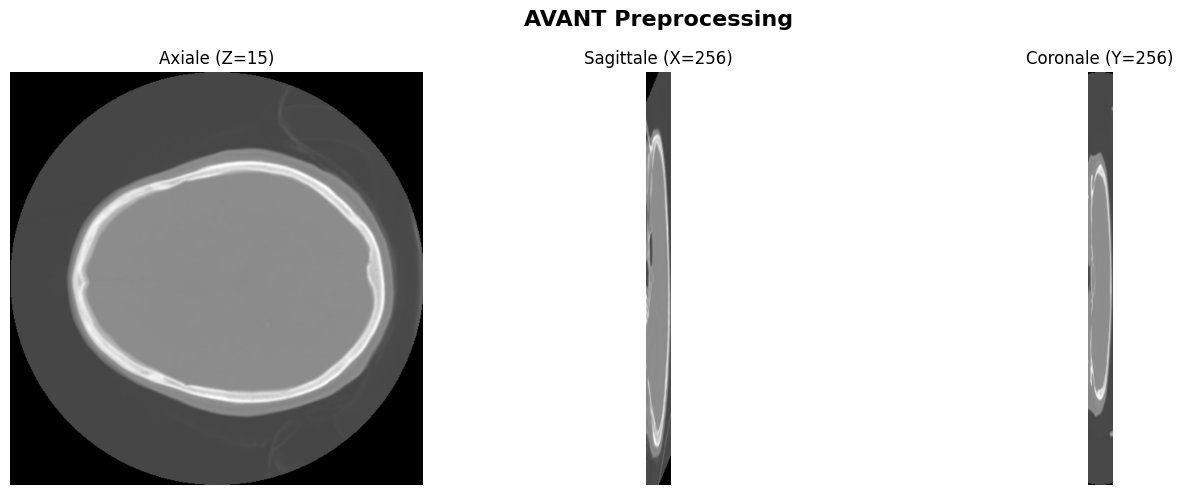


=== Visualisation APRÈS preprocessing ===
Min: 0.00, Max: 1.00, Mean: 0.23


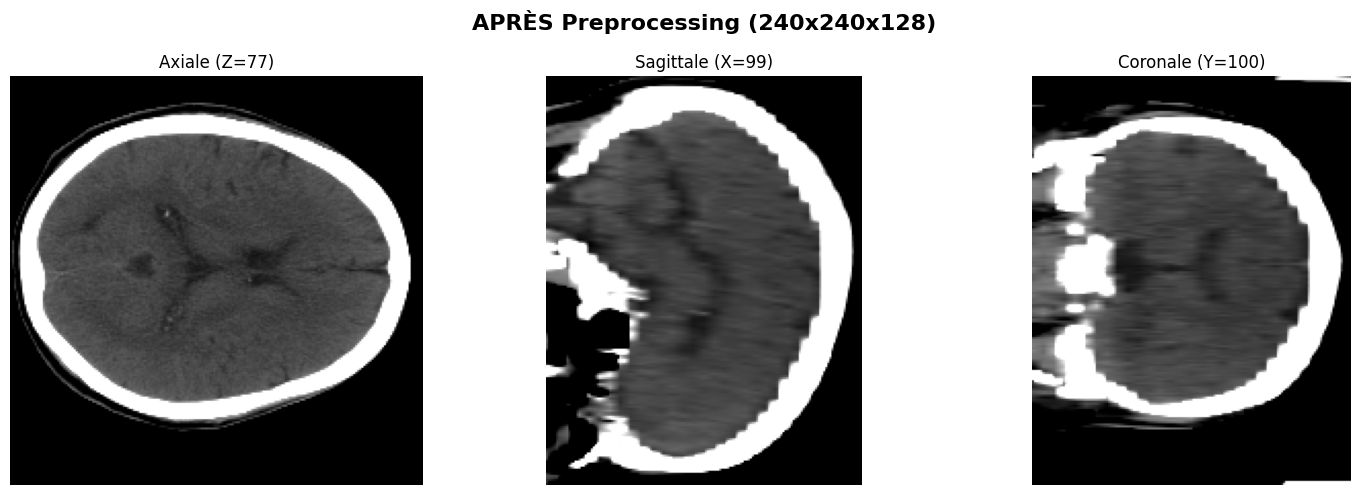

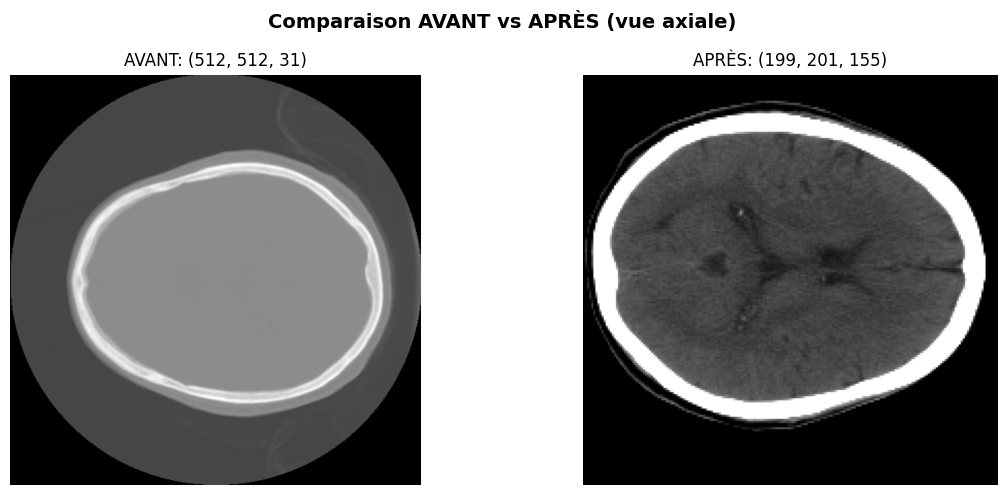


=== STATS COMPARATIVES ===
Shape AVANT:  (512, 512, 31)
Shape APRÈS:  (1, 199, 201, 155)
Ratio resize: X=2.57, Y=2.55, Z=0.20

Intensités AVANT: [-2048.0, 2117.0]
Intensités APRÈS: [0.000, 1.000]


In [30]:
import numpy as np
import matplotlib.pyplot as plt

def show_3d_slices(image, title, slice_idx=None):
    """
    Affiche 3 vues (axiale, sagittale, coronale) d'une image 3D
    """
    # Enlève la dimension channel si présente
    if image.ndim == 4:
        image = image[0]  # [C, H, W, D] -> [H, W, D]
    
    # Prend la slice du milieu si non spécifiée
    if slice_idx is None:
        slice_idx = {
            'axial': image.shape[2] // 2,      # milieu en Z
            'sagittal': image.shape[0] // 2,   # milieu en X
            'coronal': image.shape[1] // 2     # milieu en Y
        }
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Vue axiale (Z)
    axes[0].imshow(image[:, :, slice_idx['axial']], cmap='gray')
    axes[0].set_title(f"Axiale (Z={slice_idx['axial']})")
    axes[0].axis('off')
    
    # Vue sagittale (X)
    axes[1].imshow(image[slice_idx['sagittal'], :, :], cmap='gray')
    axes[1].set_title(f"Sagittale (X={slice_idx['sagittal']})")
    axes[1].axis('off')
    
    # Vue coronale (Y)
    axes[2].imshow(image[:, slice_idx['coronal'], :], cmap='gray')
    axes[2].set_title(f"Coronale (Y={slice_idx['coronal']})")
    axes[2].axis('off')
    
    plt.tight_layout()
    return fig

# Convertir en numpy si tensor
if hasattr(image_load, 'numpy'):
    image_before = image_load.cpu().numpy()
else:
    image_before = np.array(image_load)

if hasattr(processed['image'], 'numpy'):
    image_after = processed['image'].cpu().numpy()
else:
    image_after = np.array(processed['image'])

# Afficher AVANT
print("\n=== Visualisation AVANT preprocessing ===")
print(f"Min: {image_before.min():.2f}, Max: {image_before.max():.2f}, Mean: {image_before.mean():.2f}")
fig1 = show_3d_slices(image_before, "AVANT Preprocessing")
plt.show()

# Afficher APRÈS
print("\n=== Visualisation APRÈS preprocessing ===")
print(f"Min: {image_after.min():.2f}, Max: {image_after.max():.2f}, Mean: {image_after.mean():.2f}")
fig2 = show_3d_slices(image_after, "APRÈS Preprocessing (240x240x128)")
plt.show()

# Comparaison côte à côte d'une seule slice
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Comparaison AVANT vs APRÈS (vue axiale)", fontsize=14, fontweight='bold')

# AVANT
img_before_slice = image_before[0] if image_before.ndim == 4 else image_before
z_mid_before = img_before_slice.shape[2] // 2
axes[0].imshow(img_before_slice[:, :, z_mid_before], cmap='gray')
axes[0].set_title(f"AVANT: {img_before_slice.shape}")
axes[0].axis('off')

# APRÈS
img_after_slice = image_after[0] if image_after.ndim == 4 else image_after
z_mid_after = img_after_slice.shape[2] // 2
axes[1].imshow(img_after_slice[:, :, z_mid_after], cmap='gray')
axes[1].set_title(f"APRÈS: {img_after_slice.shape}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Stats comparatives
print("\n=== STATS COMPARATIVES ===")
print(f"Shape AVANT:  {image_before.shape}")
print(f"Shape APRÈS:  {image_after.shape}")
print(f"Ratio resize: X={image_before.shape[-3]/image_after.shape[-3]:.2f}, "
      f"Y={image_before.shape[-2]/image_after.shape[-2]:.2f}, "
      f"Z={image_before.shape[-1]/image_after.shape[-1]:.2f}")
print(f"\nIntensités AVANT: [{image_before.min():.1f}, {image_before.max():.1f}]")
print(f"Intensités APRÈS: [{image_after.min():.3f}, {image_after.max():.3f}]")

Stride calculé: (72, 72, 72)
Positions de départ en hauteur: [0, 72, 103]
Positions de départ en largeur: [0, 72, 105]
Positions de départ en profondeur: [0, 59]
📦 INFORMATIONS SUR LES PATCHES
Nombre total de patches: 18
Shape de chaque patch: torch.Size([1, 96, 96, 96])
Label (identique pour tous): [1. 0. 0. 0. 1. 0.]
Task: classification
Shape patches stacked: torch.Size([18, 1, 96, 96, 96])

🎨 Génération des visualisations...

1️⃣ Grille de tous les patches...


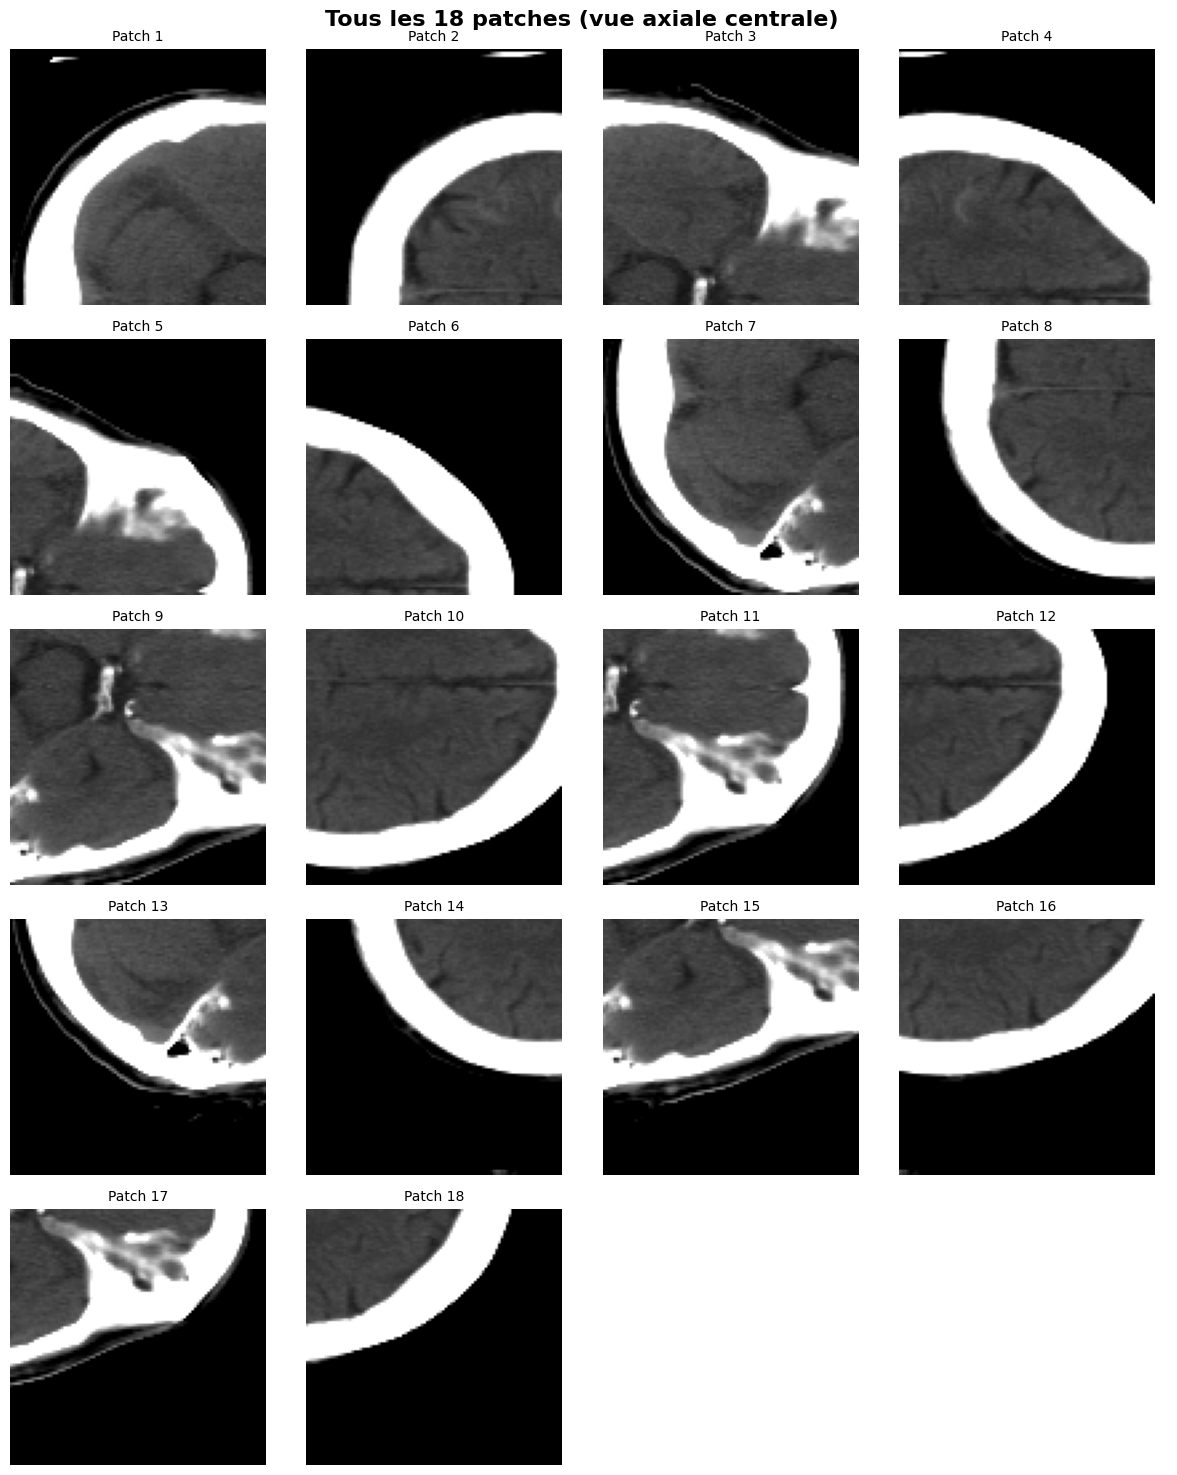


2️⃣ Positions des patches dans l'image...

📊 Statistiques de couverture:
  - Min couverture par voxel: 1
  - Max couverture par voxel: 8
  - Couverture moyenne: 2.57
  - % de l'image couvert: 100.0%


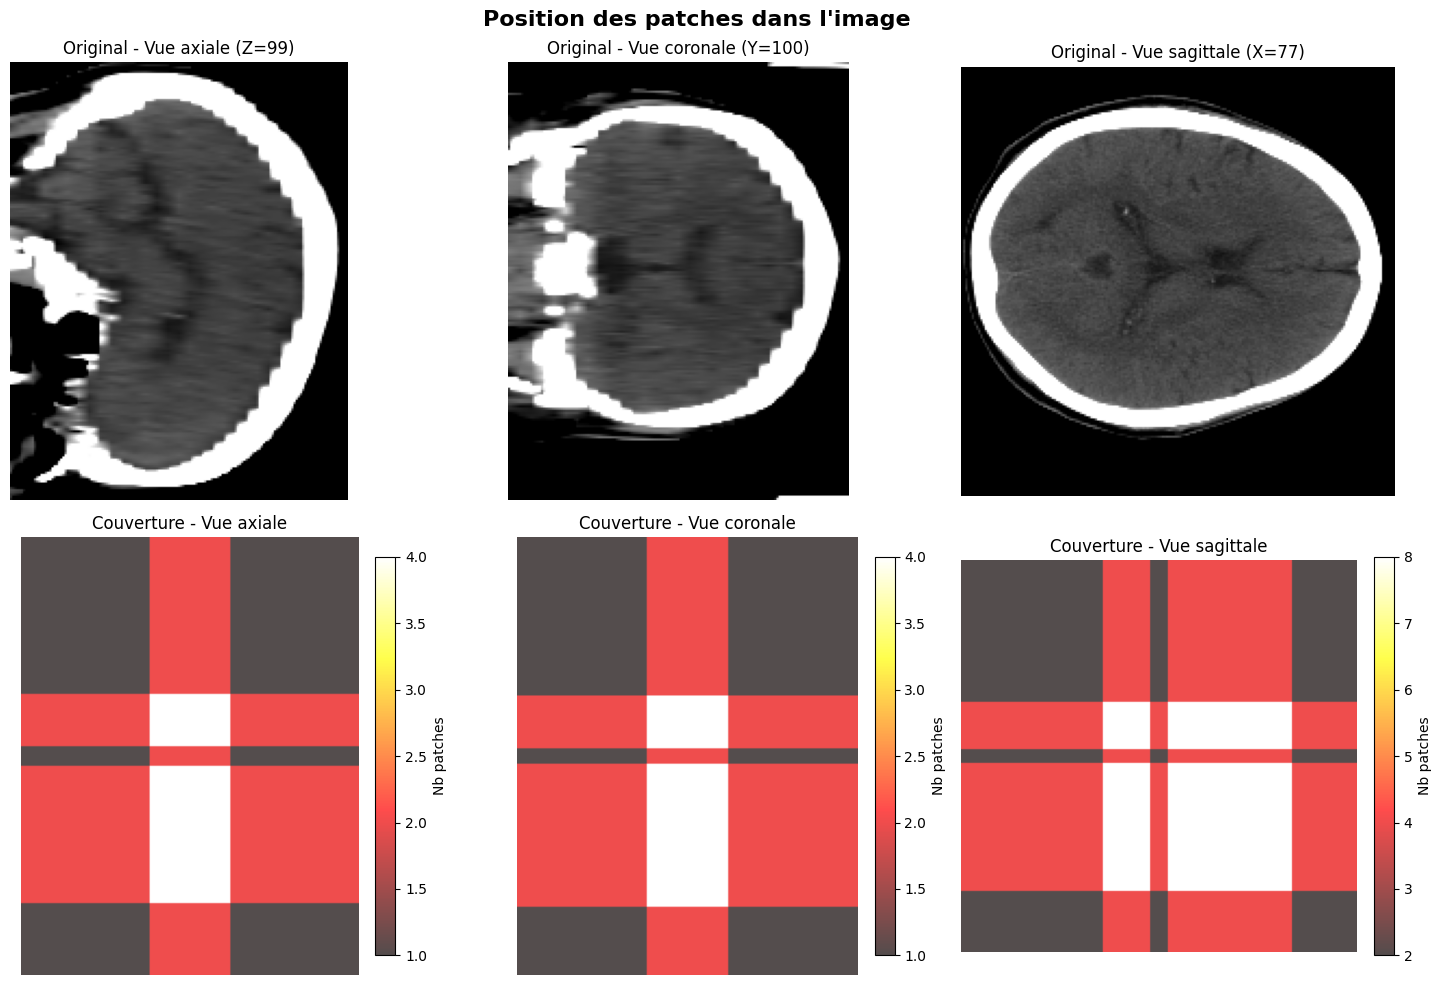


3️⃣ Détail de quelques patches...


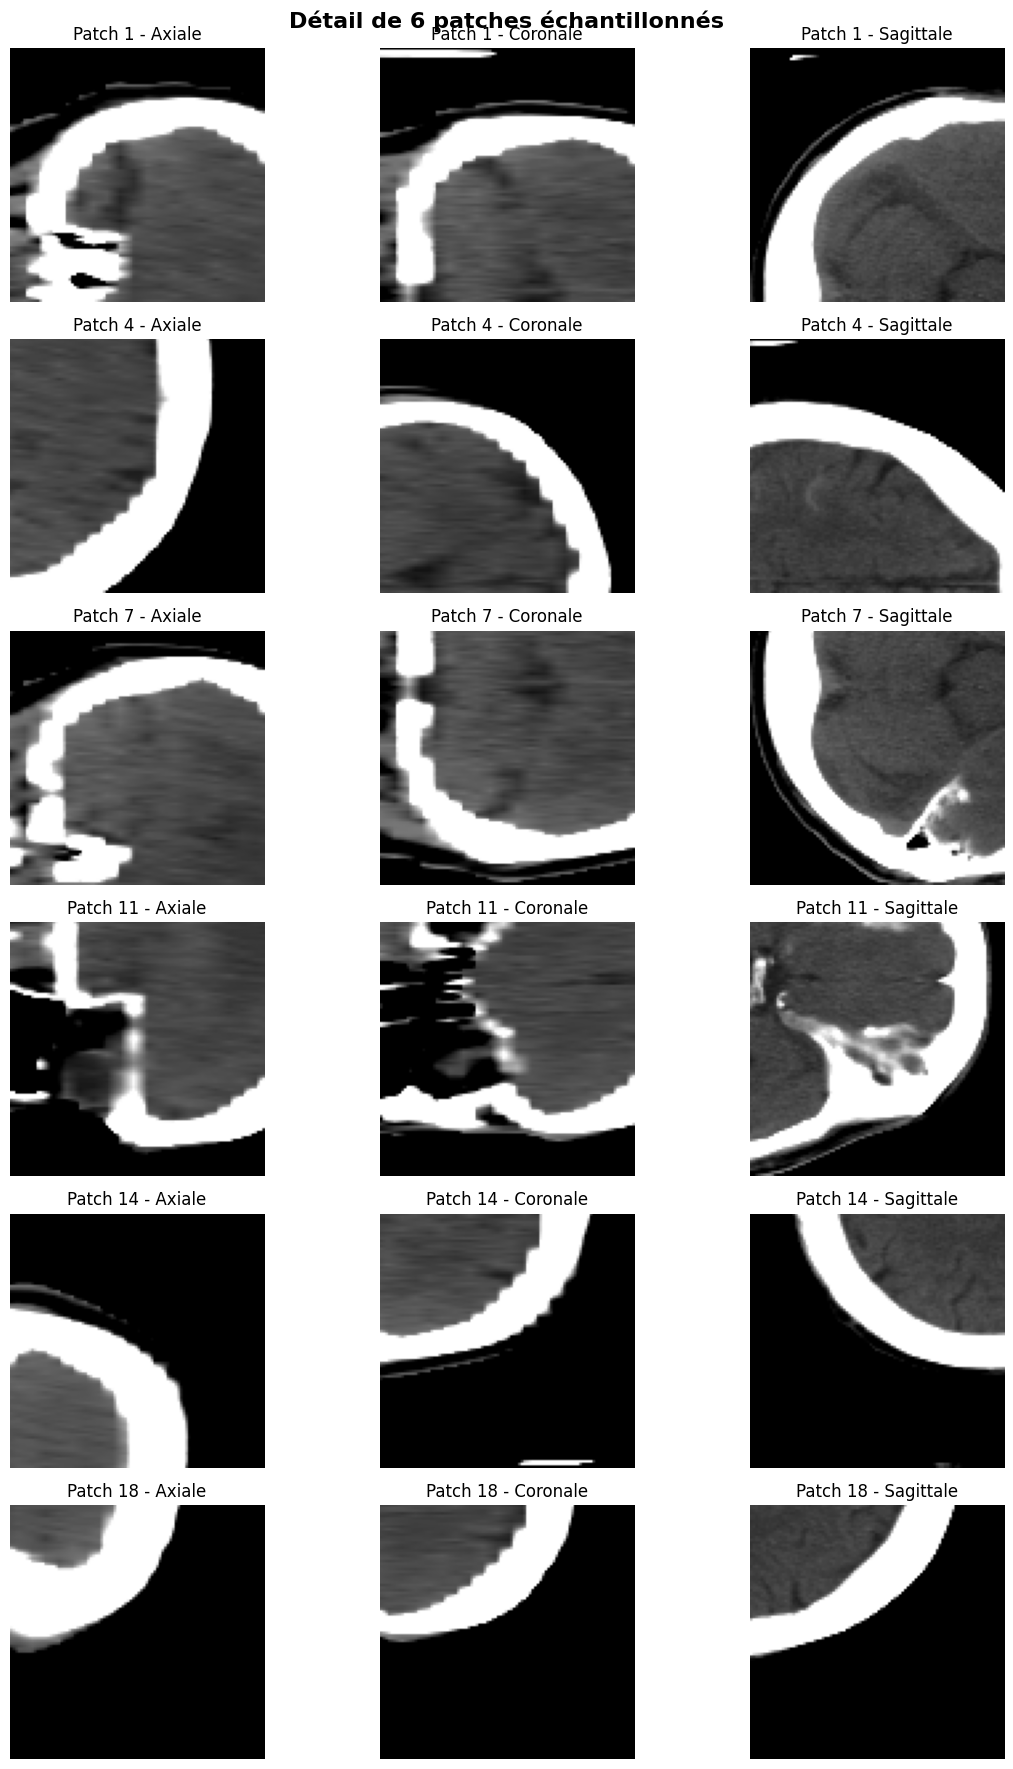


✅ Visualisations terminées!

💾 Si tu veux sauvegarder:
fig1.savefig('patches_grid.png', dpi=150, bbox_inches='tight')
fig2.savefig('patches_positions.png', dpi=150, bbox_inches='tight')
fig3.savefig('patches_detail.png', dpi=150, bbox_inches='tight')


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Extraire les patches
patches_list = extract_sliding_window_patches(
    processed['image'], 
    processed['label'],
    roi_size=(96, 96, 96),
    overlap=0.25
)

print("="*60)
print(f"📦 INFORMATIONS SUR LES PATCHES")
print("="*60)
print(f"Nombre total de patches: {len(patches_list)}")
print(f"Shape de chaque patch: {patches_list[0]['image'].shape}")
print(f"Label (identique pour tous): {patches_list[0]['label']}")
print(f"Task: {patches_list[0]['task']}")
print("="*60)

# Stack tous les patches pour la visualisation
patches_stacked = torch.stack([p['image'] for p in patches_list], dim=0)
print(f"Shape patches stacked: {patches_stacked.shape}")
print("="*60)

# ============ VISUALISATION 1: Grille de tous les patches ============

def visualize_all_patches_grid(patches_tensor, n_cols=4, slice_type='middle'):
    """
    Affiche tous les patches dans une grille
    """
    n_patches = patches_tensor.shape[0]
    n_rows = (n_patches + n_cols - 1) // n_cols  # Arrondi supérieur
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
    fig.suptitle(f"Tous les {n_patches} patches (vue axiale centrale)", 
                 fontsize=16, fontweight='bold')
    
    # Flatten axes pour itération facile
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes_flat = axes.flatten()
    
    for i in range(n_patches):
        patch = patches_tensor[i, 0]  # [C, H, W, D] -> [H, W, D]
        
        # Prend la slice du milieu en Z
        if slice_type == 'middle':
            slice_idx = patch.shape[2] // 2
        else:
            slice_idx = slice_type
        
        axes_flat[i].imshow(patch[:, :, slice_idx], cmap='gray', vmin=0, vmax=1)
        axes_flat[i].set_title(f"Patch {i+1}", fontsize=10)
        axes_flat[i].axis('off')
    
    # Cacher les axes vides
    for i in range(n_patches, len(axes_flat)):
        axes_flat[i].axis('off')
    
    plt.tight_layout()
    return fig

# ============ VISUALISATION 2: Overlay des positions sur l'image ============

def visualize_patch_positions(original_image, patches_list, roi_size=(96, 96, 96)):
    """
    Montre où sont situés les patches sur l'image originale.
    Reconstruit les positions depuis extract_sliding_window_patches.
    """
    # Prépare l'image
    if original_image.ndim == 4:
        img = original_image[0]  # [C, H, W, D] -> [H, W, D]
    else:
        img = original_image
    
    # Convertir en numpy si tensor
    if hasattr(img, 'numpy'):
        img = img.cpu().numpy()
    else:
        img = np.array(img)
    
    # Crée une carte de couverture
    coverage_map = np.zeros_like(img)
    
    # Recalcule les positions (même logique que extract_sliding_window_patches)
    C, H, W, D = original_image.shape
    overlap = 0.25  # Doit correspondre à celui utilisé
    stride = tuple(int(r * (1 - overlap)) for r in roi_size)
    
    def get_starts(dim_size, roi_dim, stride_dim):
        starts = list(range(0, dim_size - roi_dim + 1, stride_dim))
        if starts[-1] + roi_dim < dim_size:
            starts.append(dim_size - roi_dim)
        return starts
    
    h_starts = get_starts(H, roi_size[0], stride[0])
    w_starts = get_starts(W, roi_size[1], stride[1])
    d_starts = get_starts(D, roi_size[2], stride[2])
    
    import itertools
    positions = list(itertools.product(h_starts, w_starts, d_starts))
    
    for h, w, d in positions:
        h_end = h + roi_size[0]
        w_end = w + roi_size[1]
        d_end = d + roi_size[2]
        
        coverage_map[h:h_end, w:w_end, d:d_end] += 1
    
    # Visualise 3 vues
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Position des patches dans l'image", fontsize=16, fontweight='bold')
    
    z_mid = img.shape[0] // 2
    y_mid = img.shape[1] // 2
    x_mid = img.shape[2] // 2
    
    # Ligne 1: Image originale
    axes[0, 0].imshow(img[z_mid, :, :], cmap='gray')
    axes[0, 0].set_title(f"Original - Vue axiale (Z={z_mid})")
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img[:, y_mid, :], cmap='gray')
    axes[0, 1].set_title(f"Original - Vue coronale (Y={y_mid})")
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(img[:, :, x_mid], cmap='gray')
    axes[0, 2].set_title(f"Original - Vue sagittale (X={x_mid})")
    axes[0, 2].axis('off')
    
    # Ligne 2: Carte de couverture (combien de patches couvrent chaque voxel)
    im1 = axes[1, 0].imshow(coverage_map[z_mid, :, :], cmap='hot', alpha=0.7)
    axes[1, 0].set_title(f"Couverture - Vue axiale")
    axes[1, 0].axis('off')
    plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04, label='Nb patches')
    
    im2 = axes[1, 1].imshow(coverage_map[:, y_mid, :], cmap='hot', alpha=0.7)
    axes[1, 1].set_title(f"Couverture - Vue coronale")
    axes[1, 1].axis('off')
    plt.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04, label='Nb patches')
    
    im3 = axes[1, 2].imshow(coverage_map[:, :, x_mid], cmap='hot', alpha=0.7)
    axes[1, 2].set_title(f"Couverture - Vue sagittale")
    axes[1, 2].axis('off')
    plt.colorbar(im3, ax=axes[1, 2], fraction=0.046, pad=0.04, label='Nb patches')
    
    plt.tight_layout()
    
    print(f"\n📊 Statistiques de couverture:")
    print(f"  - Min couverture par voxel: {coverage_map.min():.0f}")
    print(f"  - Max couverture par voxel: {coverage_map.max():.0f}")
    print(f"  - Couverture moyenne: {coverage_map.mean():.2f}")
    print(f"  - % de l'image couvert: {(coverage_map > 0).sum() / coverage_map.size * 100:.1f}%")
    
    return fig

# ============ VISUALISATION 3: Quelques patches en détail ============

def visualize_sample_patches(patches_tensor, n_samples=6):
    """
    Affiche quelques patches en détail avec leurs 3 vues
    """
    n_patches = min(n_samples, patches_tensor.shape[0])
    indices = np.linspace(0, patches_tensor.shape[0]-1, n_patches, dtype=int)
    
    fig, axes = plt.subplots(n_patches, 3, figsize=(12, n_patches*3))
    fig.suptitle(f"Détail de {n_patches} patches échantillonnés", 
                 fontsize=16, fontweight='bold')
    
    if n_patches == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        patch = patches_tensor[idx, 0]  # [C, H, W, D] -> [H, W, D]
        
        # 3 vues du patch
        z_mid = patch.shape[0] // 2
        y_mid = patch.shape[1] // 2
        x_mid = patch.shape[2] // 2
        
        axes[i, 0].imshow(patch[z_mid, :, :], cmap='gray', vmin=0, vmax=1)
        axes[i, 0].set_title(f"Patch {idx+1} - Axiale")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(patch[:, y_mid, :], cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title(f"Patch {idx+1} - Coronale")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(patch[:, :, x_mid], cmap='gray', vmin=0, vmax=1)
        axes[i, 2].set_title(f"Patch {idx+1} - Sagittale")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    return fig

# ============ AFFICHAGE ============

print("\n🎨 Génération des visualisations...\n")

# Vis 1: Grille de tous les patches
print("1️⃣ Grille de tous les patches...")
fig1 = visualize_all_patches_grid(patches_stacked, n_cols=4)
plt.show()

# Vis 2: Positions des patches
print("\n2️⃣ Positions des patches dans l'image...")
fig2 = visualize_patch_positions(
    processed['image'], 
    patches_list,
    roi_size=(96, 96, 96)
)
plt.show()

# Vis 3: Quelques patches en détail
print("\n3️⃣ Détail de quelques patches...")
fig3 = visualize_sample_patches(patches_stacked, n_samples=6)
plt.show()

print("\n✅ Visualisations terminées!")
print(f"\n💾 Si tu veux sauvegarder:")
print(f"fig1.savefig('patches_grid.png', dpi=150, bbox_inches='tight')")
print(f"fig2.savefig('patches_positions.png', dpi=150, bbox_inches='tight')")
print(f"fig3.savefig('patches_detail.png', dpi=150, bbox_inches='tight')")

Forward

In [45]:
import torch



# # ============ EXEMPLE SIMPLE ============
# print("\n EXEMPLE 1: Concept de base")


# # Crée un tensor simple
x_simple = torch.arange(24).reshape(2, 3, 4)
print(f"Tensor original shape: {x_simple.shape}")
print(f"  → 2 batchs, 3 patches, 4 features")
print(f"\nContenu:\n{x_simple}\n")

# # Reshape avec view
x_flat = x_simple.view(-1, 4)  # Fusionne batch et patches
print(f"Après view(-1, 4): {x_flat.shape}")
print(f"  → 6 éléments (2*3), 4 features")
print(f"\nContenu:\n{x_flat}\n")

# Reshape back
x_back = x_flat.view(2, 3, 4)
print(f"Après view(2, 3, 4): {x_back.shape}")
print(f"  → Retour à l'original!")
print(f"\nContenu:\n{x_back}\n")
print(f"✅ Identique à l'original? {torch.equal(x_simple, x_back)}")


# # ============ TON CAS: IMAGES 3D ============
# print("\n" + "="*70)
# print("🧠 EXEMPLE 2: Ton cas avec images médicales 3D")
# print("-" * 70)

# # Simule ton cas: batch de 2 images, 12 patches chacune
# B = 2  # Batch size
# N = 12  # Nombre de patches par image
# C = 1  # Channels (grayscale)
# H, W, D = 96, 96, 96  # Dimensions spatiales

# x = torch.randn(B, N, C, H, W, D)
# print(f"\n📥 INPUT (après DataLoader):")
# print(f"   Shape: {x.shape}")
# print(f"   → {B} images dans le batch")
# print(f"   → {N} patches par image")
# print(f"   → Chaque patch: [{C}, {H}, {W}, {D}]")

# # ÉTAPE 1: Flatten batch et patches
# batch_size, num_patches = x.shape[0], x.shape[1]
# x_flat = x.view(batch_size * num_patches, *x.shape[2:])

# print(f"\n🔄 APRÈS view(B*N, C, H, W, D):")
# print(f"   Shape: {x_flat.shape}")
# print(f"   → {batch_size * num_patches} patches au total (2*12=24)")
# print(f"   → L'encodeur voit 24 images indépendantes!")
# print(f"   💡 Cela permet de faire UN SEUL forward pour tous les patches")

# # Simule l'encodeur (réduit les dimensions spatiales)
# # En vrai: ton réseau transforme [24, 1, 96, 96, 96] → [24, 256, 6, 6, 6]
# features = 256
# x_encoded = torch.randn(batch_size * num_patches, features, 6, 6, 6)

# print(f"\n🧬 APRÈS l'encodeur:")
# print(f"   Shape: {x_encoded.shape}")
# print(f"   → Features extraites pour chaque patch")

# # ÉTAPE 2: Reshape back pour séparer batch et patches
# x_reshaped = x_encoded.view(batch_size, num_patches, *x_encoded.shape[1:])

# print(f"\n🔙 APRÈS view(B, N, features, H', W', D'):")
# print(f"   Shape: {x_reshaped.shape}")
# print(f"   → Retour à la structure [batch, patches, features, ...]")
# print(f"   → Image 1: {num_patches} patches de features")
# print(f"   → Image 2: {num_patches} patches de features")

# # ÉTAPE 3: Agrégation (max pooling sur les patches)
# x_aggregated = torch.max(x_reshaped, dim=1)[0]

# print(f"\n📊 APRÈS torch.max(dim=1)[0] (agrégation):")
# print(f"   Shape: {x_aggregated.shape}")
# print(f"   → Plus de dimension 'patches' !")
# print(f"   → Une représentation par image du batch")
# print(f"   💡 On a pris le maximum sur les {num_patches} patches")


# # ============ VISUALISATION DES INDICES ============
# print("\n" + "="*70)
# print("🔢 EXEMPLE 3: Où vont les éléments?")
# print("-" * 70)

# # Petit exemple pour voir la réorganisation
# mini = torch.arange(2 * 3 * 4).reshape(2, 3, 4)
# print(f"\nTensor [2, 3, 4] (2 batchs, 3 patches, 4 features):")
# print(mini)

# mini_flat = mini.view(-1, 4)
# print(f"\nAprès view(-1, 4) → [6, 4]:")
# print(mini_flat)
# print(f"\n💡 Les 3 patches du batch 0 (lignes 0,1,2)")
# print(f"💡 Les 3 patches du batch 1 (lignes 3,4,5)")
# print(f"   → Tous les patches sont mis 'à plat' pour le forward")

# # ============ RÉSUMÉ ============
# print("\n" + "="*70)
# print("📝 RÉSUMÉ")
# print("="*70)
# print("""
# 1. INPUT:       [B, N, C, H, W, D]  → Batch de patches
# 2. view():      [B*N, C, H, W, D]   → Tous les patches à plat
# 3. Encodeur:    [B*N, features, ...]→ Features de tous les patches
# 4. view():      [B, N, features,...] → Re-sépare par batch
# 5. max(dim=1):  [B, features, ...]  → Agrège les patches par image

# 🎯 AVANTAGE: Un seul forward pour tous les patches au lieu de N forwards!
#              C'est beaucoup plus efficace !
# """)

Tensor original shape: torch.Size([2, 3, 4])
  → 2 batchs, 3 patches, 4 features

Contenu:
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])

Après view(-1, 4): torch.Size([6, 4])
  → 6 éléments (2*3), 4 features

Contenu:
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]])

Après view(2, 3, 4): torch.Size([2, 3, 4])
  → Retour à l'original!

Contenu:
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])

✅ Identique à l'original? True


Dataloader

In [ ]:
train_transforms = T_mtsk.TaskBasedTransform_V2(keys=["image", "label"])
    
   
    # Datasets
train_dataset = PersistentDataset(
        train_data, 
        transform=train_transforms,
        cache_dir=os.path.join(config.SAVE_DIR, "cache_train")
    )
    
    # DataLoaders
train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True, 
        num_workers=8,
        persistent_workers=True,
        collate_fn=utils.multitask_collate_fn
    )

for batch_idx, batch in enumerate(train_loader):
    if batch_idx >= 3:  # Regarde seulement les 3 premiers batchs
        break
    
    print(f"\n--- BATCH {batch_idx + 1} ---")
    print(f"Type: {type(batch)}")
    
    if isinstance(batch, dict):
        print(f"Clés: {list(batch.keys())}")
        
        # Segmentation
        if "segmentation" in batch and batch["segmentation"] is not None:
            seg = batch["segmentation"]
            print(f"\n📍 SEGMENTATION:")
            print(f"  - Image shape: {seg['image'].shape}")
            print(f"  - Label shape: {seg['label'].shape}")
            print(f"  - Device: {seg['image'].device}")
            print(f"  - Memory: {seg['image'].element_size() * seg['image'].nelement() / 1024**2:.2f} MB")
        
        # Classification
        if "classification" in batch and batch["classification"] is not None:
            cls = batch["classification"]
            print(f"\n🔬 CLASSIFICATION:")
            print(f"  - Image shape: {cls['image'].shape}")
            
            # Analyse détaillée
            if cls['image'].dim() == 6:
                B, N, C, H, W, D = cls['image'].shape
                print(f"    → Batch size: {B}")
                print(f"    → Patches par image: {N}")
                print(f"    → Taille patch: [{C}, {H}, {W}, {D}]")
                print(f"    → TOTAL patches dans ce batch: {B * N}")
            elif cls['image'].dim() == 5:
                N, C, H, W, D = cls['image'].shape
                print(f"    → Patches: {N}")
                print(f"    → Taille patch: [{C}, {H}, {W}, {D}]")
            
            print(f"  - Label shape: {cls['label'].shape}")
            print(f"  - Device: {cls['image'].device}")
            
            # Mémoire utilisée
            mem_mb = cls['image'].element_size() * cls['image'].nelement() / 1024**2
            print(f"  - Memory: {mem_mb:.2f} MB")
            
            # Alerte si trop de mémoire
            if mem_mb > 500:
                print(f"  ⚠️  ATTENTION: {mem_mb:.2f} MB par batch, c'est beaucoup!")
    
    else:
        print(f"Type inattendu: {type(batch)}")

# Calcul de la mémoire totale estimée pour une epoch
print("\n" + "="*70)
print("💾 ESTIMATION MÉMOIRE")
print("="*70)

try:
    one_batch = next(iter(train_loader))
    
    total_mem = 0
    if "segmentation" in one_batch and one_batch["segmentation"] is not None:
        seg_mem = one_batch["segmentation"]['image'].element_size() * one_batch["segmentation"]['image'].nelement() / 1024**2
        total_mem += seg_mem
        print(f"Segmentation par batch: {seg_mem:.2f} MB")
    
    if "classification" in one_batch and one_batch["classification"] is not None:
        cls_mem = one_batch["classification"]['image'].element_size() * one_batch["classification"]['image'].nelement() / 1024**2
        total_mem += cls_mem
        print(f"Classification par batch: {cls_mem:.2f} MB")
        
        # Détail des patches
        if one_batch["classification"]['image'].dim() == 6:
            B, N = one_batch["classification"]['image'].shape[:2]
            print(f"\n🔢 Détail patches classification:")
            print(f"  - {B} images × {N} patches = {B*N} patches par batch")
            print(f"  - Avec batch_size={config.batch_size}, ça fait beaucoup!")
    
    print(f"\nMémoire TOTALE par batch: {total_mem:.2f} MB")
    
    # Estimation pour epoch complète
    num_batches = len(train_loader)
    print(f"Nombre de batchs dans une epoch: {num_batches}")
    print(f"Pic mémoire estimé: {total_mem:.2f} MB (un batch à la fois)")
    
except Exception as e:
    print(f"Erreur lors de l'estimation: {e}")

print("\n" + "="*70)
print("✅ Inspection terminée")
print("="*70)

>>> TaskBasedTransform initialized


/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile


--- BATCH 1 ---
Type: <class 'dict'>
Clés: ['classification', 'segmentation']

🔬 CLASSIFICATION:
  - Image shape: torch.Size([50, 1, 96, 96, 96])
    → Patches: 50
    → Taille patch: [1, 96, 96, 96]
  - Label shape: torch.Size([50, 6])
  - Device: cpu
  - Memory: 168.75 MB

--- BATCH 2 ---
Type: <class 'dict'>
Clés: ['classification', 'segmentation']

🔬 CLASSIFICATION:
  - Image shape: torch.Size([50, 1, 96, 96, 96])
    → Patches: 50
    → Taille patch: [1, 96, 96, 96]
  - Label shape: torch.Size([50, 6])
  - Device: cpu
  - Memory: 168.75 MB

--- BATCH 3 ---
Type: <class 'dict'>
Clés: ['classification', 'segmentation']

🔬 CLASSIFICATION:
  - Image shape: torch.Size([50, 1, 96, 96, 96])
    → Patches: 50
    → Taille patch: [1, 96, 96, 96]
  - Label shape: torch.Size([50, 6])
  - Device: cpu
  - Memory: 168.75 MB

💾 ESTIMATION MÉMOIRE


/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile

Classification par batch: 168.75 MB

Mémoire TOTALE par batch: 168.75 MB
Nombre de batchs dans une epoch: 448
Pic mémoire estimé: 168.75 MB (un batch à la fois)

✅ Inspection terminée


/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile